# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import make_scorer
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0)
]

In [113]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

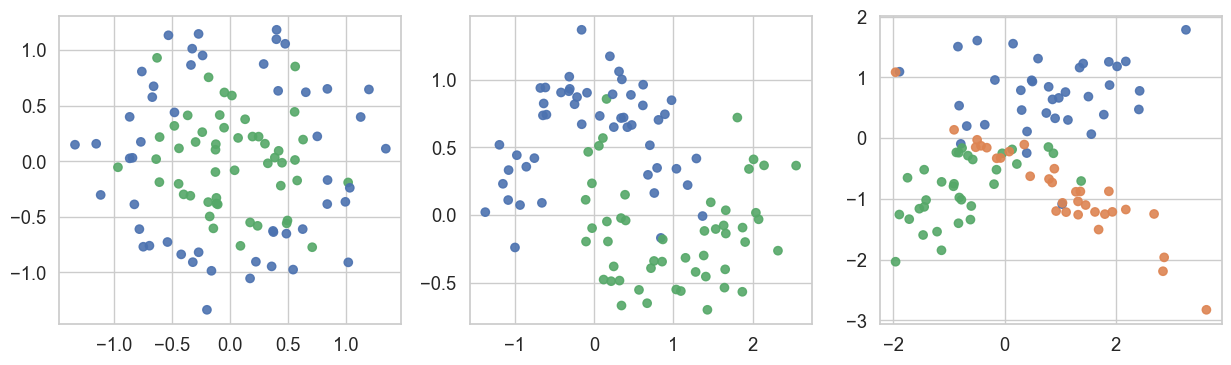

In [116]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.9)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [ ]:
def plot_surface(classifier, features, targets):
    step_size = 0.01
    color_palette = sns.color_palette(n_colors=len(np.unique(targets)))
    color_map = ListedColormap(color_palette)
    
    min_x, max_x = features[:, 0].min() - 1, features[:, 0].max() + 1
    min_y, max_y = features[:, 1].min() - 1, features[:, 1].max() + 1
    
    grid_x, grid_y = np.meshgrid(
        np.arange(min_x, max_x, step_size), 
        np.arange(min_y, max_y, step_size)
    )
    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    predictions = classifier.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
    predictions_grid = predictions.reshape(grid_x.shape)
    
    contour = plt.contourf(grid_x, grid_y, predictions_grid, cmap=color_map, alpha=0.2)

    plt.scatter(
        features[:, 0], 
        features[:, 1], 
        c=targets, 
        cmap=color_map, 
        alpha=.7, 
        edgecolors=np.array(color_palette)[targets], 
        linewidths=2
    )

In [ ]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def evaluate_and_plot_tree(features, labels, data_name):
    X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(
        features, labels, test_size=0.3, random_state=42
    )

    model_tree = DecisionTreeClassifier(random_state=42)
    model_tree.fit(X_train_data, y_train_data)

    print(f"\nНабор данных: {data_name}")

    predictions_train = model_tree.predict(X_train_data)
    accuracy_train = accuracy_score(y_train_data, predictions_train)
    print("Точность на обучающей выборке:", accuracy_train)

    predictions_test = model_tree.predict(X_test_data)
    accuracy_test = accuracy_score(y_test_data, predictions_test)
    print("Точность на тестовой выборке:", accuracy_test)

    plt.figure(figsize=(5, 4))
    plot_surface(model_tree, features, labels)
    plt.title(f"Граница решений: {data_name}")
    plt.show()


names_datasets = ["Круги", "Полумесяцы", "Классификация"]

for index_dataset, (data_features, data_labels) in enumerate(datasets):
    name_current = names_datasets[index_dataset]
    evaluate_and_plot_tree(data_features, data_labels, name_current)

__Ответ:__

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [ ]:
max_depth_values = [1, 5, 7, None]
min_leaf_samples = [1, 5, 10]

dataset_titles = ["Circles", "Moons", "Classification"]

for dataset_index, (features, labels) in enumerate(datasets):
    train_X, test_X, train_y, test_y = train_test_split(features, labels, test_size=0.3, random_state=42)

    current_dataset = dataset_titles[dataset_index]
    print(f"\nDataset: {current_dataset}")

    plt.figure(figsize=(15, 15))
    subplot_index = 1

    for max_depth_param in max_depth_values:
        for min_leaf_param in min_leaf_samples:
            # Обучение модели
            tree_model = DecisionTreeClassifier(
                max_depth=max_depth_param,
                min_samples_leaf=min_leaf_param,
                random_state=42
            )
            tree_model.fit(train_X, train_y)

            # Оценка качества
            predictions_train = tree_model.predict(train_X)
            predictions_test = tree_model.predict(test_X)

            accuracy_train = accuracy_score(train_y, predictions_train)
            accuracy_test = accuracy_score(test_y, predictions_test)

            # Визуализация
            plt.subplot(len(max_depth_values), len(min_leaf_samples), subplot_index)
            plot_surface(tree_model, features, labels)
            plt.title(
                f"depth={max_depth_param}, leaf={min_leaf_param}\n"
                f"train={accuracy_train:.2f}, test={accuracy_test:.2f}"
            )
            subplot_index += 1

    plt.suptitle(f"Decision surfaces: {current_dataset}")
    plt.tight_layout()
    plt.show()

__Ответ:__

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

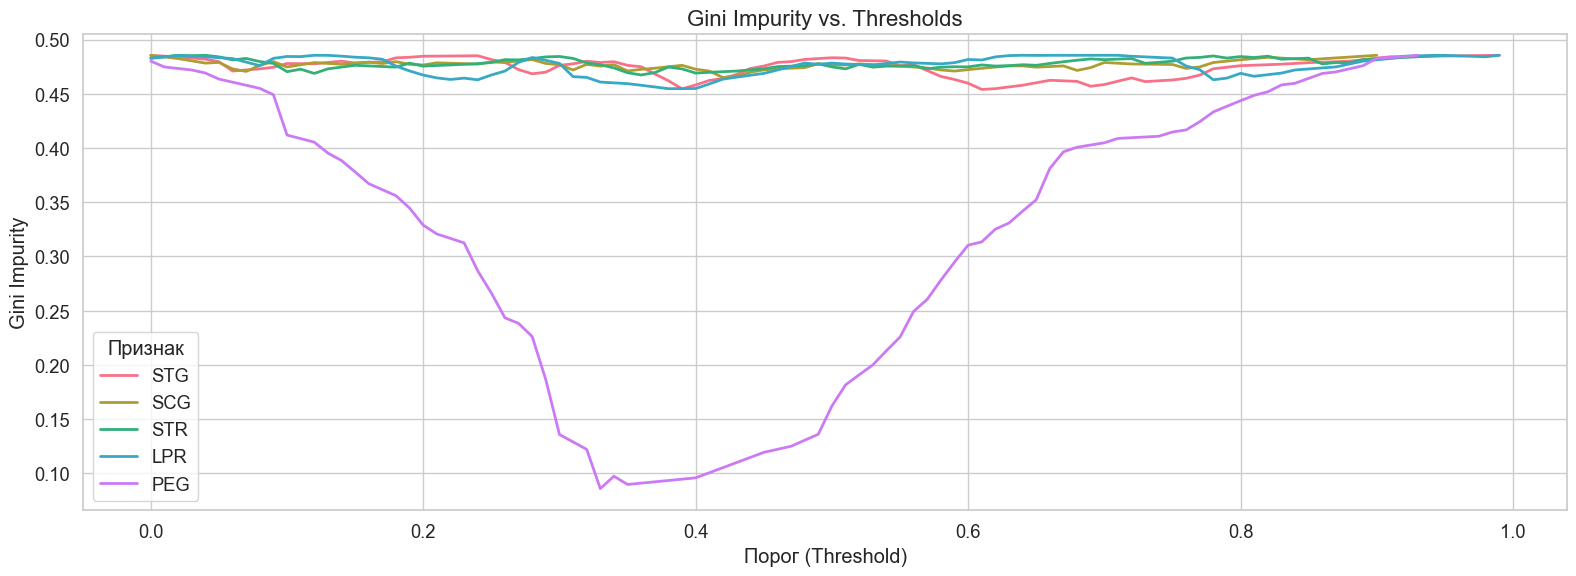

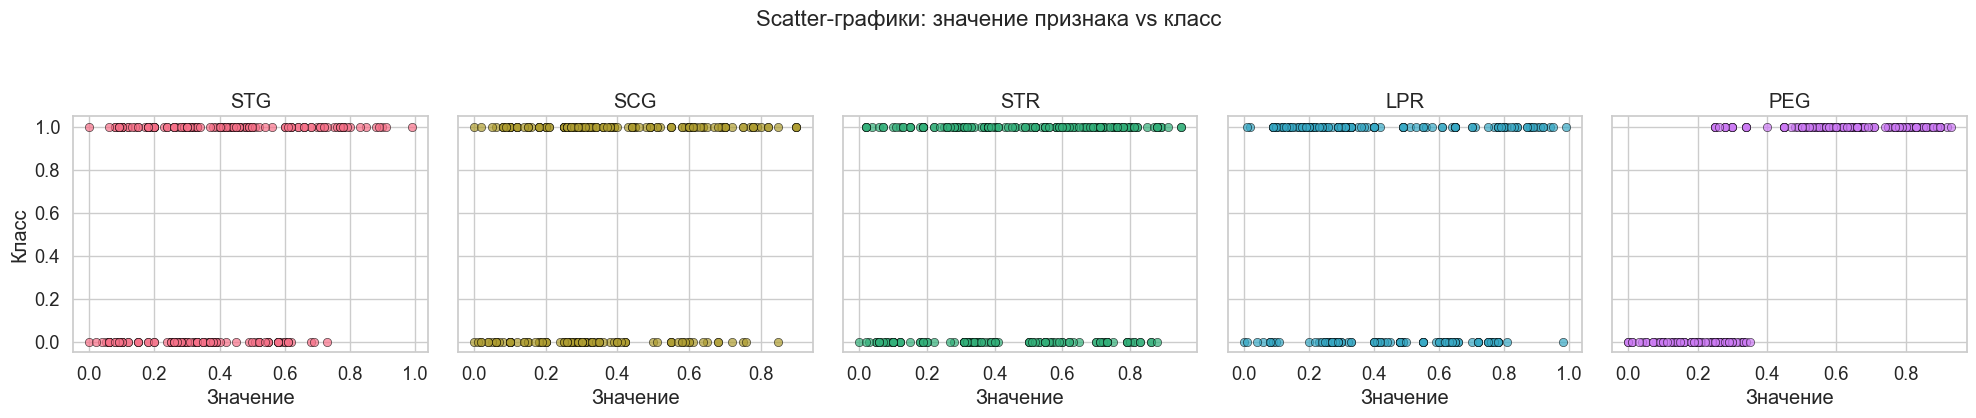

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)

dataset_students = pd.read_csv('datasets/students.csv')
feature_labels = dataset_students.columns[:-1]
data_features = dataset_students.iloc[:, :-1].values
data_targets = dataset_students.iloc[:, -1].values

def calculate_gini_impurity(class_labels):
    """Вычисление неопределённости Джини"""
    if len(class_labels) == 0:
        return 0
    probabilities_classes = np.bincount(class_labels) / len(class_labels)
    return 1.0 - np.sum(probabilities_classes ** 2)

def calculate_gini_for_thresholds(feature_values, labels):
    """Расчёт Джини для всех уникальных порогов"""
    distinct_thresholds = np.unique(feature_values)
    impurity_values = []

    for threshold_current in distinct_thresholds:
        left_group = labels[feature_values <= threshold_current]
        right_group = labels[feature_values > threshold_current]

        weight_left = len(left_group) / len(labels)
        weight_right = 1 - weight_left

        gini_weighted = weight_left * calculate_gini_impurity(left_group) + \
                       weight_right * calculate_gini_impurity(right_group)
        impurity_values.append(gini_weighted)

    return distinct_thresholds, impurity_values

plt.figure(figsize=(16, 6))
color_scheme = sns.color_palette("husl", len(feature_labels))

for idx_feature, name_feature in enumerate(feature_labels):
    current_feature = data_features[:, idx_feature]
    thresholds_list, gini_list = calculate_gini_for_thresholds(current_feature, data_targets)
    plt.plot(thresholds_list, gini_list, label=name_feature,
             color=color_scheme[idx_feature], linewidth=2)

plt.title('Gini Impurity vs. Thresholds', fontsize=16)
plt.xlabel('Порог (Threshold)')
plt.ylabel('Gini Impurity')
plt.legend(title='Признак')
plt.grid(True)
plt.tight_layout()
plt.show()

figure, axes_list = plt.subplots(1, len(feature_labels), figsize=(20, 4), sharey=True)

for idx_feature, name_feature in enumerate(feature_labels):
    sns.scatterplot(
        x=data_features[:, idx_feature],
        y=data_targets,
        ax=axes_list[idx_feature],
        color=color_scheme[idx_feature],
        alpha=0.7,
        edgecolor='black'
    )
    axes_list[idx_feature].set_title(name_feature)
    axes_list[idx_feature].set_xlabel('Значение')

    if idx_feature == 0:
        axes_list[idx_feature].set_ylabel('Класс')

plt.suptitle('Scatter-графики: значение признака vs класс', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [105]:
from hw2code import DecisionTree

columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
    "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
    "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

df = pd.read_csv('datasets/agaricus-lepiota.data', names=columns)

for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X, y = df.drop("class", axis=1).values, df["class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

tree = DecisionTree(["categorical"] * X.shape[1])
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

display(f"Accuracy: {accuracy_score(y_test, y_pred):.5f}")


'Accuracy: 1.00000'

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).


Оценка параметра: max_depth


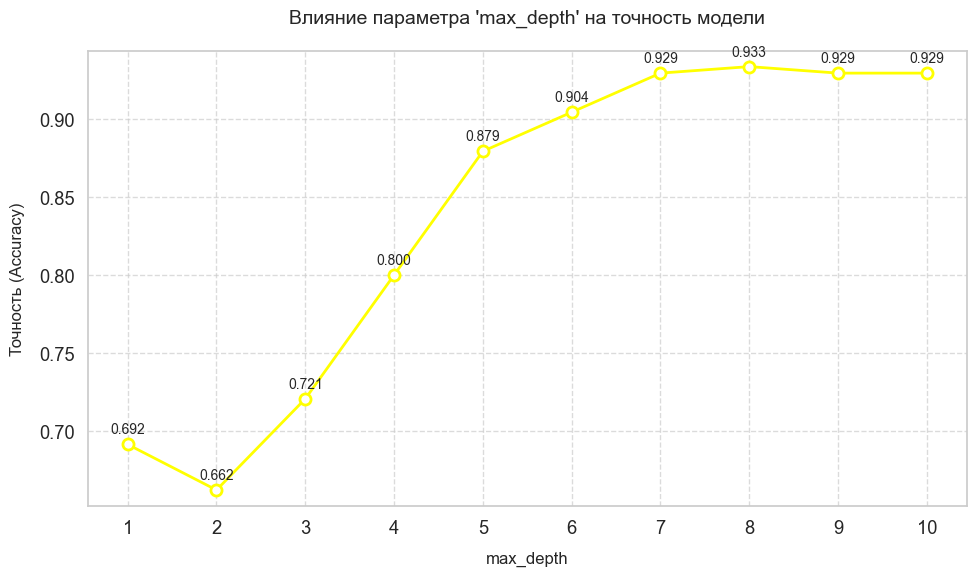

Лучшее значение: 8 с точностью 0.9333

Оценка параметра: min_samples_split


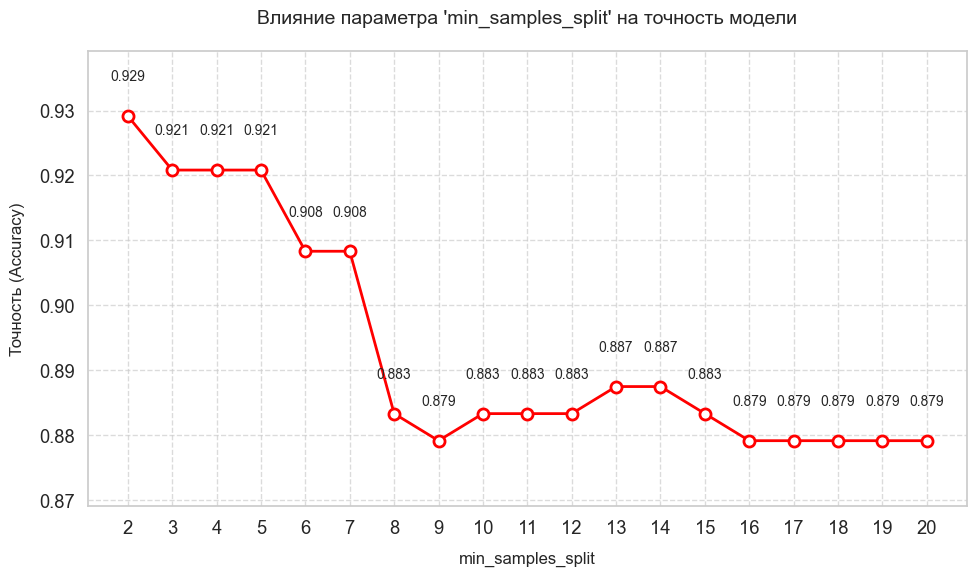

Лучшее значение: 2 с точностью 0.9292

Оценка параметра: min_samples_leaf


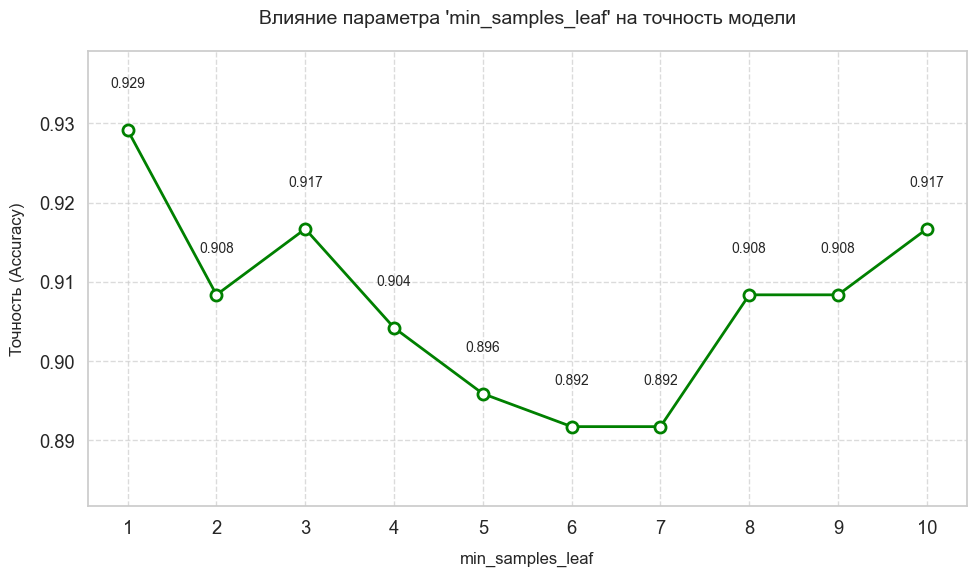

Лучшее значение: 1 с точностью 0.9292


In [110]:
def load_data(filepath):
    data_frame = pd.read_csv(filepath)
    features = data_frame.drop('V10', axis=1).values
    labels = (data_frame['V10'] == 'positive').astype(int).values
    return features, labels

def evaluate_parameter(train_features, test_features, train_labels, test_labels,
                      feature_type_list, parameter_name, value_range,
                      figsize=(10, 6), color='royalblue'):
    """Оценивает влияние параметра на качество модели"""
    accuracy_list = []

    for param_value in value_range:
        model_params = {parameter_name: param_value}
        tree_model = DecisionTree(feature_type_list, **model_params)
        tree_model.fit(train_features, train_labels)

        predictions = tree_model.predict(test_features)
        accuracy = accuracy_score(test_labels, predictions)
        accuracy_list.append(accuracy)

    plt.figure(figsize=figsize)
    plt.plot(value_range, accuracy_list,
             marker='o',
             markersize=8,
             linewidth=2,
             color=color,
             markerfacecolor='white',
             markeredgewidth=2)

    plt.title(f"Влияние параметра '{parameter_name}' на точность модели",
              pad=20, fontsize=14)
    plt.xlabel(parameter_name, fontsize=12, labelpad=10)
    plt.ylabel("Точность (Accuracy)", fontsize=12, labelpad=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(value_range)
    plt.ylim(min(accuracy_list) - 0.01, max(accuracy_list) + 0.01)

    for x_val, y_val in zip(value_range, accuracy_list):
        plt.text(x_val, y_val + 0.005, f"{y_val:.3f}",
                 ha='center',
                 va='bottom',
                 fontsize=10)

    plt.tight_layout()
    plt.show()

    return accuracy_list

features_data, target_data = load_data('datasets/tic-tac-toe-endgame.csv')
types_of_features = ['categorical'] * features_data.shape[1]

# Разделение на обучающую и тестовую выборки
train_X, test_X, train_y, test_y = train_test_split(
    features_data,
    target_data,
    test_size=0.25,
    random_state=42,
    stratify=target_data
)

parameter_configurations = {
    'max_depth': range(1, 11),
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 11)
}

for (param_key, param_values), graph_color in zip(parameter_configurations.items(), ['yellow', 'red', 'green']):
    print(f"\nОценка параметра: {param_key}")

    accuracy_results = evaluate_parameter(
        train_X,
        test_X,
        train_y,
        test_y,
        feature_type_list=types_of_features,
        parameter_name=param_key,
        value_range=param_values,
        color=graph_color
    )

    optimal_index = accuracy_results.index(max(accuracy_results))
    optimal_value = param_values[optimal_index]
    optimal_accuracy = accuracy_results[optimal_index]

    print(f"Лучшее значение: {optimal_value} с точностью {optimal_accuracy:.4f}")

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [118]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def load_and_preprocess(dataset_name, url):
    try:
        data_frame = pd.read_csv(url, header=None)
    except Exception as error:
        raise ValueError(f"Ошибка загрузки данных из {url}: {str(error)}")

    dataset_configurations = {
        'mushrooms': {
            'X_cols': slice(1, None),
            'y_mapping': {'e': 0, 'p': 1}
        },
        'tic_tac_toe': {
            'X_cols': slice(None, -1),
            'y_mapping': {'negative': 0, 'positive': 1}
        },
        'cars': {
            'X_cols': slice(None, -1),
            'y_mapping': {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
        },
        'nursery': {
            'X_cols': slice(None, -1),
            'y_mapping': {
                'not_recom': 0,
                'recommend': 0,
                'very_recom': 1,
                'priority': 1,
                'spec_prior': 1
            }
        }
    }

    if dataset_name not in dataset_configurations:
        available_options = ", ".join(dataset_configurations.keys())
        raise ValueError(
            f"Неподдерживаемый набор данных '{dataset_name}'. "
            f"Доступные варианты: {available_options}"
        )

    config = dataset_configurations[dataset_name]

    features = data_frame.iloc[:, config['X_cols']]
    target = data_frame.iloc[:, -1].replace(config['y_mapping'])

    encoded_features = features.apply(lambda column: LabelEncoder().fit_transform(column.astype(str)))

    if not np.issubdtype(target.dtype, np.number):
        encoded_target = LabelEncoder().fit_transform(target.astype(str))
    else:
        encoded_target = target.values

    return encoded_features, encoded_target

In [119]:
class SklearnCompatibleTree(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types):
        self.feature_types = feature_types
        self.model = DecisionTree(feature_types=feature_types)

    def fit(self, X, y):
        self.model.fit(np.array(X), np.array(y))
        return self

    def predict(self, X):
        return self.model.predict(np.array(X))

In [120]:
datasets = {
    "mushrooms": "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data",
    "tic_tac_toe": "https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data",
    "cars": "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data",
    "nursery": "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
}
results = {}

In [121]:
from sklearn.model_selection import cross_val_score

for name, url in datasets.items():
    X, y = load_and_preprocess(name, url)

    # 1. Реальные признаки
    tree_real = SklearnCompatibleTree(["real"] * X.shape[1])
    acc_real = cross_val_score(tree_real, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # 2. Категориальные признаки
    tree_cat = SklearnCompatibleTree(["categorical"] * X.shape[1])
    acc_cat = cross_val_score(tree_cat, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # 3. One-hot + вещественные признаки
    ohe = OneHotEncoder(sparse_output=False)
    X_ohe = ohe.fit_transform(X)
    tree_ohe = SklearnCompatibleTree(["real"] * X_ohe.shape[1])
    acc_ohe = cross_val_score(tree_ohe, X_ohe, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    # 4. Sklearn
    sk_tree = DecisionTreeClassifier()
    acc_sk = cross_val_score(sk_tree, X, y, cv=10, scoring=make_scorer(accuracy_score)).mean()

    results[name] = [acc_real, acc_cat, acc_ohe, acc_sk]

df_results = pd.DataFrame(results, index=["custom_real", "custom_categorical", "custom_ohe", "sklearn_tree"]).T

display(df_results)


,custom_real,custom_categorical,custom_ohe,sklearn_tree
mushrooms,1.000000,1.000000,1.000000,0.988192
tic_tac_toe,0.467533,0.541458,0.543575,0.757127
cars,0.942647,0.967546,0.919495,0.943285
nursery,0.999691,0.999846,0.999537,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

1. **Эффективность моделей на разных данных:**

- Данные из nursery, mushrooms и cars оказались настолько "предсказуемыми", что деревья справились с задачей почти идеально — точность 95-99%, вне зависимости от реализации.
- А вот tic_tac_toe оказался "непредсказуемым" — точность варьировалась в широком диапазоне, от 46% до 76%.

2. **Какие подходы оказались лучше:**

- Модель SklearnDecisionTree в целом лидировала, особенно на тех наборах, где различия между методами были заметны.
- Собственные реализации:
- - Обработка признаков как категориальных работала лучше, чем приведение к вещественным.
- - One-hot кодирование оказалось неоднозначным: в одних случаях давало преимущество, в других — ухудшало результат.

3. **Почему были различия:**

- Реализация в sklearn более отработана: используются продвинутые эвристики, оптимизации и стратегии выбора разбиений.
- Категориальные признаки естественнее работают с данными, у которых нет числового смысла.

4. **Что можно улучшить:**

- Наиболее изменчивые результаты были на tic_tac_toe, где модель оказалась чувствительной к кодировке.
- Повысить качество можно, например, подбором гиперпараметров, использованием других способов обработки признаков или переходом к более сложным моделям.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [ ]:
print('Ничто не имеет значения')